# Step 1 - Data Acquisition & Preparing the Dataset

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import ast

# Path to the raw data (CSV file)
DATA_PATH = Path("../data/raw")
csv_file = DATA_PATH / "listings.csv"

df = pd.read_csv(csv_file, low_memory=False)

# Check dataset size (rows, columns)
df.shape

# Overview of columns, data types, and missing values
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 36261 entries, 0 to 36260
Data columns (total 85 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            36261 non-null  int64  
 1   listing_url                                   36261 non-null  str    
 2   scrape_id                                     36261 non-null  int64  
 3   last_scraped                                  36261 non-null  str    
 4   source                                        36261 non-null  str    
 5   name                                          36259 non-null  str    
 6   description                                   34893 non-null  str    
 7   neighborhood_overview                         18130 non-null  str    
 8   picture_url                                   36261 non-null  str    
 9   host_id                                       36261 non-null  int64  
 1

# Step 2 - Data Cleaning and Handling Inconsistencies

Step 2 of the project was done by Maya.

## Detect and rectify data type inconsistencies

In [3]:
# Work on a copy so the original df stays untouched
df0 = df.copy()

#### Convert dates from str to datetime

In [4]:
# Columns that should be dates
date_cols = ["last_scraped", "host_since", "calendar_last_scraped", "first_review", "last_review"]

# Convert date columns from string -> datetime (invalid parses become NaT)
for c in date_cols:
    if c in df0.columns:
        df0[c] = pd.to_datetime(df0[c], errors="coerce")

# Confirm new dtypes
df0[date_cols].dtypes

last_scraped             datetime64[us]
host_since               datetime64[us]
calendar_last_scraped    datetime64[us]
first_review             datetime64[us]
last_review              datetime64[us]
dtype: object

#### Convert "t/f" strings into booleans

In [5]:
# Convert consistent 't'/'f' string columns to boolean
bool_cols = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
    "has_availability",
]

# Fix boolean columns safely: normalize strings first, then map
for c in bool_cols:
    if c in df0.columns:
        df0[c] = (
            df0[c]
            .astype(str)          # ensure string
            .str.strip()          # remove whitespace
            .str.lower()          # normalize case
            .map({"t": True, "f": False})
            .astype("boolean")     
        )

# Confirm new dtypes and values
df0[bool_cols].dtypes

host_is_superhost         boolean
host_has_profile_pic      boolean
host_identity_verified    boolean
instant_bookable          boolean
has_availability          boolean
dtype: object

#### Convert numeric strings into float

In [6]:
# Convert percent strings like "95%" -> 0.95
pct_cols = ["host_response_rate", "host_acceptance_rate"]

for c in pct_cols:
    s = df0[c].astype("string").str.strip()          # clean whitespace
    s = s.str.replace("%", "", regex=False)          # remove % sign
    df0[c] = pd.to_numeric(s, errors="coerce") / 100

# Confirm new dtypes and values
df0[pct_cols].dtypes

host_response_rate      Float64
host_acceptance_rate    Float64
dtype: object

#### Convert all IDs into strings

In [7]:
id_cols = [
    "id",
    "host_id",
    "host_profile_id",
    "license"
]

for c in id_cols:
    if c in df0.columns:
        df0[c] = df0[c].astype("string")

# Confirm new dtypes and values
df0[id_cols].dtypes

id                 string
host_id            string
host_profile_id    string
license            string
dtype: object

#### Convert lists encoded as string

In [8]:
def parse_amenities(x):
    # If missing, return empty list + flag
    if pd.isna(x):
        return [], False

    x = str(x).strip()

    if x == "[]":
        return [], True

    # Try JSON parsing
    try:
        out = json.loads(x)
        return out if isinstance(out, list) else [], True
    except Exception:
        pass

    # Fallback: Python literal list parsing
    try:
        out = ast.literal_eval(x)
        return out if isinstance(out, list) else [], True
    except Exception:
        return [], False

# Apply parsing and keep a success flag so we can audit parsing quality
parsed = df0["amenities"].apply(parse_amenities)
df0["amenities_list"] = parsed.apply(lambda t: t[0])

# Clean each amenity string inside the list
def clean_amenity_list(lst):
    cleaned = []
    for a in lst:
        a = str(a).strip()              # remove leading/trailing spaces
        a = " ".join(a.split())         # collapse repeated whitespace
        a = a.lower()                   # standard casing
        if a != "":
            cleaned.append(a)

    # Dedupe within a listing (keeps order)
    seen = set()
    deduped = []
    for a in cleaned:
        if a not in seen:
            seen.add(a)
            deduped.append(a)

    return deduped

df0["amenities_list"] = df0["amenities_list"].apply(clean_amenity_list)

# Count amenities per listing
df0["amenities_count"] = df0["amenities_list"].apply(len).astype("int64")

In [9]:
# Same process for host_verifications
df0["host_verifications"] = df0["host_verifications"].apply(
    lambda x: ast.literal_eval(x) if pd.notna(x) else x
)

#### Remove columns that are completely empty

In [10]:
# Identify columns with all missing values
empty_cols = df.columns[df.isna().all()].tolist()
empty_cols

# Remove empty columns
df0 = df0.drop(columns=empty_cols)

#### Remove zero variability columns

In [11]:
non_list_cols = [
    c for c in df0.columns
    if not df0[c].dropna().apply(lambda x: isinstance(x, list)).any()
]

zero_var_cols = [c for c in non_list_cols if df0[c].nunique(dropna=True) <= 1]

# Remove
df0 = df0.drop(columns=zero_var_cols)


## Ensure uniform formatting across variables

#### Define feature groups

In [12]:
# 1) URL-like columns (don’t lowercase)
url_cols = [
    "listing_url", "picture_url", "host_url",
    "host_profile_url", "host_thumbnail_url", "host_picture_url"
]

# 2) Long free-text columns (don’t lowercase)
long_text_cols = ["name", "description", "neighborhood_overview", "host_about"]

# 3) Category-like columns (safe to lowercase)
cat_cols = [
    "source", "host_location", "host_response_time", "host_neighbourhood",
    "neighbourhood", "neighbourhood_cleansed", "neighbourhood_group_cleansed",
    "property_type", "room_type", "license"
]

# 4) Text columns (clear whitespace)
whitespace_cols = [
    "listing_url",
    "source",
    "name",
    "description",
    "neighborhood_overview",
    "picture_url",
    "host_url",
    "host_profile_url",
    "host_name",
    "host_location",
    "host_about",
    "host_response_time",
    "host_neighbourhood",
    "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "property_type",
    "room_type",
    "bathrooms_text",
    "license",
]

#### Strip + normalize whitespace for all string columns

In [13]:
# Clean whitespace for all string columns
for c in whitespace_cols:
    df0[c] = (
        df0[c]
        .astype("string")
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
    )

In [14]:
# Lowercase category-like columns only
for c in cat_cols:
    if c in df0.columns:
        df0[c] = df0[c].astype("string").str.lower()

#### Group all missing strings

In [15]:
missing_like = {"n/a", "na", "none", "nan", "null", "unknown", ""}

for c in cat_cols + long_text_cols:
    if c in df0.columns:
        s = df0[c].astype("string")
        df0[c] = s.mask(s.str.lower().isin(missing_like))

#### Parse categorical data into numeric values

In [16]:
# bathroom_text
bt = df0["bathrooms_text"]

num = pd.to_numeric(
    bt.str.extract(r"(\d+(\.\d+)?)")[0],
    errors="coerce"
)

half_only = bt.str.fullmatch(r"(a\s+)?half[-\s]?bath(s)?", na=False)

df0["bathroom_shared"] = bt.str.contains("shared", na=False)
df0["bathroom_private"] = bt.str.contains("private", na=False)

In [17]:
# host_response_time

hrt = df0["host_response_time"]

response_time_map = {
    "within an hour": 1,
    "within a few hours": 2,
    "within a day": 3,
    "a few days or more": 4
}

df0["host_response_time_num"] = df0["host_response_time"].map(response_time_map)

# Handle missing values
df0["host_response_time_num"] = df0["host_response_time_num"].fillna(5)

#### Drop irrelevant features

In [18]:
relevant_features = [
    # Identifiers
    "id",
    "host_id",

    # Listing metadata
    "name",

    # Host experience & tenure
    "hosts_time_as_user_years",
    "hosts_time_as_host_years",

    # Host responsiveness & quality
    "host_response_time_num",
    "host_response_rate",
    "host_acceptance_rate",
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "host_verifications",

    # Host scale
    "host_listings_count",
    "host_total_listings_count",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",

    # Listing location
    "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "latitude",
    "longitude",

    # Property & capacity
    "property_type",
    "room_type",
    "accommodates",
    "bedrooms",
    "beds",

    # Bathrooms
    "bathrooms",
    "bathroom_shared",
    "bathroom_private",

    # Stay constraints
    "minimum_nights",
    "maximum_nights",
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",

    # Availability & demand
    "has_availability",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "availability_eoy",
    "estimated_occupancy_l365d",

    # Reviews & ratings
    "number_of_reviews",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "number_of_reviews_ly",
    "reviews_per_month",
    "first_review",
    "last_review",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",

    # Amenities
    "amenities_list",
    "amenities_count",

    # Booking behavior
    "instant_bookable",
]

df_eda = df0[relevant_features].copy()

## Address duplicate data entries

#### Check for duplicate IDs

In [19]:
df_eda["id"].duplicated().sum()

np.int64(0)

In [20]:
# Check for full row duplicates
df_dup = df0.copy()

for col in df_dup.columns:
    if df_dup[col].apply(lambda x: isinstance(x, list)).any():
        df_dup[col] = df_dup[col].apply(
            lambda x: tuple(sorted(x)) if isinstance(x, list) else x
        )

full_duplicates = df_dup.duplicated().sum()
print("Full row duplicates:", full_duplicates)

Full row duplicates: 0


#### Check for near duplicates

In [21]:
near_duplicates = df0.duplicated(
    subset=["host_id", "name", "latitude", "longitude"]
).sum()

print("Near duplicates:", near_duplicates)

Near duplicates: 375


In [22]:
# Inspect and handle near duplicates
key_cols = ["host_id", "name", "latitude", "longitude"]

df0["last_review"] = pd.to_datetime(df0["last_review"], errors="coerce")

# Helper: count missing per row (lower is better)
df0["_missing_count"] = df0.isna().sum(axis=1)

# Sort so the "best" row appears first in each near-duplicate group
df0 = df0.sort_values(
    by=["number_of_reviews", "last_review", "_missing_count"],
    ascending=[False, False, True]
)

before = len(df0)

# Keep the best row per group
df0 = df0.drop_duplicates(subset=key_cols, keep="first")

after = len(df0)

df0 = df0.drop(columns=["_missing_count"])

print("Removed near-duplicate rows:", before - after)

Removed near-duplicate rows: 375


In [23]:
near_duplicates_after = df0.duplicated(subset=key_cols).sum()
print("Near duplicates after:", near_duplicates_after)

Near duplicates after: 0


## Identify and handle outliers

In [24]:
# Select all numeric columns
results = []

for col in df_eda.select_dtypes(include="number").columns:
    max_val = df_eda[col].max()
    p99 = df_eda[col].quantile(0.99)
    
    # Avoid division by zero
    ratio = max_val / p99 if p99 != 0 else np.nan
    
    results.append({
        "column": col,
        "max": max_val,
        "p99": p99,
        "max_to_p99_ratio": ratio,
        "flagged_over_10x": ratio > 10 if pd.notna(ratio) else False
    })

outlier_check = pd.DataFrame(results)

flagged = outlier_check[outlier_check["flagged_over_10x"] == True] \
    .sort_values("max_to_p99_ratio", ascending=False)

print("Flagged columns (max > 10x p99):", flagged.shape[0])
display(flagged.head(15))

Flagged columns (max > 10x p99): 13


,column,max,p99,max_to_p99_ratio,flagged_over_10x
18,maximum_nights,2.147484e+09,1125.0000,1.908874e+06,True
21,minimum_maximum_nights,2.147484e+09,1125.0000,1.908874e+06,True
22,maximum_maximum_nights,2.147484e+09,1125.0000,1.908874e+06,True
24,maximum_nights_avg_ntm,2.147484e+09,1125.0000,1.908874e+06,True
10,calculated_host_listings_count_shared_rooms,3.400000e+01,1.0000,3.400000e+01,True
34,number_of_reviews_ly,1.797000e+03,57.0000,3.152632e+01,True
32,number_of_reviews_ltm,1.565000e+03,59.0000,2.652542e+01,True
35,reviews_per_month,1.203700e+02,6.0389,1.993244e+01,True
33,number_of_reviews_l30d,7.400000e+01,5.0000,1.480000e+01,True
31,number_of_reviews,3.920000e+03,296.4000,1.322537e+01,True


#### Cap true data outliers 

In [25]:
night_cols = [
    "maximum_nights",
    "maximum_maximum_nights",
    "minimum_maximum_nights",
    "maximum_nights_avg_ntm"
]

for col in night_cols:
    df_eda.loc[df_eda[col] > 10000, col] = np.nan

#### Check for unrealistic negative values

In [26]:
num_cols = df_eda.select_dtypes(include="number").columns

neg_min = []
for col in num_cols:
    mn = df_eda[col].min()
    if mn < 0:
        neg_min.append([col, mn])

neg_min_df = pd.DataFrame(neg_min, columns=["column", "min_value"]).sort_values("min_value")
neg_min_df

,column,min_value
0,longitude,-74.251907


#### Verify explicit domain rules

In [27]:
checks = {
    "accommodates": (df_eda["accommodates"] < 1),
    "minimum_nights": (df_eda["minimum_nights"] < 1),
    "availability_365": (df_eda["availability_365"] < 0) | (df_eda["availability_365"] > 365),
    "host_response_rate": (df_eda["host_response_rate"] < 0) | (df_eda["host_response_rate"] > 1),
    "host_acceptance_rate": (df_eda["host_acceptance_rate"] < 0) | (df_eda["host_acceptance_rate"] > 1),
}

for name, mask in checks.items():
    if name in df_eda.columns:
        print(name, mask.sum())

accommodates 0
minimum_nights 0
availability_365 0
host_response_rate 0
host_acceptance_rate 0


In [28]:
more_checks = {
    "availability_30_range": (df_eda["availability_30"] < 0) | (df_eda["availability_30"] > 30),
    "availability_60_range": (df_eda["availability_60"] < 0) | (df_eda["availability_60"] > 60),
    "availability_90_range": (df_eda["availability_90"] < 0) | (df_eda["availability_90"] > 90),

    "beds_nonnegative": (df_eda["beds"] < 0) if "beds" in df_eda.columns else False,
    "bedrooms_nonnegative": (df_eda["bedrooms"] < 0) if "bedrooms" in df_eda.columns else False,
    "bathrooms_nonnegative": (df_eda["bathrooms"] < 0) if "bathrooms" in df_eda.columns else False,

    "review_scores_low": (df_eda["review_scores_rating"] < 0) if "review_scores_rating" in df_eda.columns else False,
    "review_scores_high": (df_eda["review_scores_rating"] > 5) if "review_scores_rating" in df_eda.columns else False,
}

for name, mask in more_checks.items():
    if isinstance(mask, bool):
        continue
    print(name, int(mask.sum()))

availability_30_range 0
availability_60_range 0
availability_90_range 0
beds_nonnegative 0
bedrooms_nonnegative 0
bathrooms_nonnegative 0
review_scores_low 0
review_scores_high 0


## Identify and handle missing values

#### Find missing values

In [29]:
missing_counts = df_eda.isna().sum()
missing_percent = (missing_counts / len(df_eda)) * 100

missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
})

missing_df = missing_df[missing_df["missing_count"] > 0]
missing_df.sort_values("missing_percent", ascending=False)

,missing_count,missing_percent
host_response_rate,15173,41.843854
beds,14891,41.066159
bathrooms,14806,40.831748
host_acceptance_rate,14741,40.652492
review_scores_location,11367,31.347729
review_scores_value,11366,31.344971
review_scores_checkin,11364,31.339456
review_scores_accuracy,11360,31.328424
review_scores_communication,11356,31.317393
review_scores_cleanliness,11351,31.303604


#### Drop rows with very low missing precentage

In [30]:
tiny_cols = [
    "maximum_maximum_nights",
    "maximum_nights_avg_ntm",
    "host_identity_verified",
    "host_verifications",
    "host_has_profile_pic",
    "host_total_listings_count",
    "host_listings_count",
    "minimum_maximum_nights",
    "maximum_minimum_nights",
    "minimum_minimum_nights",
    "name",
    "maximum_nights"
]

tiny_cols = [c for c in tiny_cols if c in df_eda.columns]

df_eda = df_eda.dropna(subset=tiny_cols)

In [31]:
# Find listings that have no review data
review_cols = [
    "review_scores_rating",
    "review_scores_cleanliness",
    "review_scores_value",
    "review_scores_location",
    "review_scores_checkin",
    "review_scores_accuracy",
    "review_scores_communication",
    "reviews_per_month",
    "first_review",
    "last_review"
]

review_cols = [c for c in review_cols if c in df_eda.columns]

# Count rows where ALL review columns are missing
all_reviews_missing = df_eda[review_cols].isna().all(axis=1).sum()

print("Rows with all review data missing:", all_reviews_missing)

# Create a new has_reviews feature
df_eda["has_reviews"] = (~df_eda["review_scores_rating"].isna()).astype(int)

# Set reviews_per_month to 0 for no review listings
df_eda.loc[df_eda["has_reviews"] == 0, "reviews_per_month"] = 0

Rows with all review data missing: 11342


In [32]:
# Create missing flags for host columns
host_cols = [
    "host_response_rate",
    "host_acceptance_rate"
]

host_cols = [c for c in host_cols if c in df_eda.columns]

for col in host_cols:
    df_eda[col + "_missing"] = df_eda[col].isna().astype(int)

# Fill numeric host metrics with median
for col in ["host_response_rate", "host_acceptance_rate"]:
    if col in df_eda.columns:
        df_eda[col] = pd.to_numeric(df_eda[col], errors="coerce")
        df_eda[col] = df_eda[col].fillna(df_eda[col].median())

#### Use KNN for missing beds/bedrooms/bathrooms

In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_eda["room_type_encoded"] = le.fit_transform(df_eda["room_type"])

knn_cols = [
    "beds",
    "bathrooms",
    "bedrooms",
    "accommodates",
    "amenities_count",
    "room_type_encoded"
]

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

scaler = StandardScaler()
scaled = scaler.fit_transform(df_eda[knn_cols])

imputer = KNNImputer(n_neighbors=5)
imputed_scaled = imputer.fit_transform(scaled)

imputed = scaler.inverse_transform(imputed_scaled)
df_eda[knn_cols] = imputed

df_eda["beds"] = df_eda["beds"].round().astype(int)
df_eda["bedrooms"] = df_eda["bedrooms"].round().astype(int)
df_eda["bathrooms"] = df_eda["bathrooms"].round(1)  # bathrooms can be 1.5

Summary: First, print the basic information of the dataset, including the number of rows and columns, the first 5 rows, all column names, and the count of each data type. This is to quickly view the overall size. Second, I compute descriptive statistics for all numerical columns (num_cols), including mean, standard deviation, minimum, quartiles, and maximum. This helps to understand the range, central tendency, and dispersion of each numerical feature, and to detect possible outliers. Third, I calculate the count and percentage of missing values for each column, filter columns with missing data, and sort them by missing percentage in descending order. Then I plot a horizontal bar chart to visually display the missing rate for each column. Forth, I select a set of representative numerical variables and plot histograms (30 bins) for each. Histograms reveal the distribution shape (e.g., normal, skewed, bimodal), central tendency, and possible outliers. Observing the distributions provides a basis for subsequent modeling or transformations (e.g., log transformation). Fifth, Drawing boxplots for the same numerical variables. For variables that are right‑skewed and have all positive values, apply natural logarithm (np.log1p) before plotting. Boxplots intuitively show the median, interquartile range, and outliers. Logarithmic transformation makes skewed distributions more symmetric, facilitating outlier identification and understanding the concentrated range of data.Sixth, it is important to select several important categorical variables, count the frequency of each category, and display the top 15 categories (if applicable) in horizontal bar charts. This quickly reveals the balance of category distributions and provides references for potential category merging or encoding later. The 7th step is to compute the correlation coefficient matrix among all numerical variables and plot a heatmap using imshow. The color intensity indicates the strength of correlation, allowing intuitive discovery of linear relationships between variables. The 8th step is to use boxplots to show the distribution of review scores (review_scores_rating) for different numbers of accommodates. Boxplots compare medians, dispersion, and outliers across groups, helping to explore whether there is a relationship between accommodates and ratings (e.g., whether more accommodates lead to lower ratings). This grouped visualization helps uncover potential patterns. The last step is geographic distribution. Since too many latitude/longitude points can make the plot overcrowded, we can randomly sample up to 5000 observations and use a scatter plot to show the geographic locations of listings (longitude on x‑axis, latitude on y‑axis). This reveals whether listings are concentrated in certain areas or if outliers exist.

#### Median-impute host time columns

In [34]:
df_eda["hosts_time_as_host_years"] = df_eda["hosts_time_as_host_years"].fillna(
    df_eda["hosts_time_as_host_years"].median()
)

df_eda["hosts_time_as_user_years"] = df_eda["hosts_time_as_user_years"].fillna(
    df_eda["hosts_time_as_user_years"].median()
)

#### Fill 'unkown' has_availability rows

In [35]:
# Convert to integer categories
df_eda["has_availability"] = df_eda["has_availability"].map({
    True: 1,
    False: 0
})

df_eda["has_availability"] = df_eda["has_availability"].fillna(2)

In [36]:
missing_summary = df_eda.isna().sum().sort_values(ascending=False)
missing_summary = missing_summary[missing_summary > 0]

missing_summary

review_scores_location         11360
review_scores_value            11359
review_scores_checkin          11357
review_scores_accuracy         11353
review_scores_communication    11349
review_scores_cleanliness      11344
last_review                    11342
review_scores_rating           11342
first_review                   11342
dtype: int64

In [37]:
print("Original shape:", df.shape)
print("Final shape:", df_eda.shape)

Original shape: (36261, 85)
Final shape: (36227, 66)


### Handling missing values - summary:

Missing values have been addressed. Listings without review data are not missing at random; they simply have no reviews. A has_reviews indicator was created to distinguish these listings, and reviews_per_month was set to 0 where applicable.

Host response metrics include missing flags to preserve information about unavailable response history before imputation. Property characteristics such as beds, bedrooms, and bathrooms were imputed using KNN based on related features. Small amounts of random missing data were either imputed or the corresponding rows were removed.

Models (using df_eda) should include has_reviews if using review-related features.

# Step 3 - EDA

Step 3 of the project was done by Yuxuan.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [46]:
print("dataset shape:", df_eda.shape)
print("\nfirst 5 rows:\n", df_eda.head())
print("\ncolnames:\n", df_eda.columns.tolist())
print("\ndatatype counts:\n", df_eda.dtypes.value_counts())

dataset shape: (36227, 66)

first 5 rows:
      id host_id                                               name  \
0  2539    2787    Superfast Wi-Fi. Clean & quiet home by the park   
1  2595    2845  Skylit Studio Oasis | Midtown Manhattan Sanctuary   
2  6848   15991                   Only 2 stops to Manhattan studio   
3  6872   16104  Uptown Sanctuary w/ Private Bath (Month to Month)   
4  6990   16800                            UES Beautiful Blue Room   

   hosts_time_as_user_years  hosts_time_as_host_years  host_response_time_num  \
0                      17.0                      14.0                     1.0   
1                      17.0                      14.0                     3.0   
2                      16.0                      14.0                     1.0   
3                      16.0                      14.0                     3.0   
4                      16.0                      14.0                     1.0   

   host_response_rate  host_acceptance_rate  host

In [47]:
# 2. descirptive stats
num_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
print("\ndescirptive stats:\n", df_eda[num_cols].describe().T)


descirptive stats:
                                                 count        mean  \
hosts_time_as_user_years                      36227.0    8.203301   
hosts_time_as_host_years                      36227.0    6.693902   
host_response_time_num                        36227.0    3.003506   
host_response_rate                            36227.0    0.948881   
host_acceptance_rate                          36227.0    0.814215   
host_listings_count                           36227.0  275.205896   
host_total_listings_count                     36227.0  374.333149   
calculated_host_listings_count                36227.0   68.393132   
calculated_host_listings_count_entire_homes   36227.0   51.394126   
calculated_host_listings_count_private_rooms  36227.0   16.253513   
calculated_host_listings_count_shared_rooms   36227.0    0.093135   
latitude                                      36227.0   40.728375   
longitude                                     36227.0  -73.947372   
accommodates 

In [48]:
# 3. na values analysis
missing = df_eda.isna().sum()
missing_pct = (missing / len(df_eda)) * 100
missing_df = pd.DataFrame({'missing number': missing, 'missing percentage': missing_pct})
missing_df = missing_df[missing_df['missing number'] > 0].sort_values('missing percentage', ascending=False)
print("\nna values:\n", missing_df)


na values:
                              missing number  missing percentage
review_scores_location                11360           31.357827
review_scores_value                   11359           31.355067
review_scores_checkin                 11357           31.349546
review_scores_accuracy                11353           31.338504
review_scores_communication           11349           31.327463
review_scores_cleanliness             11344           31.313661
first_review                          11342           31.308140
last_review                           11342           31.308140
review_scores_rating                  11342           31.308140


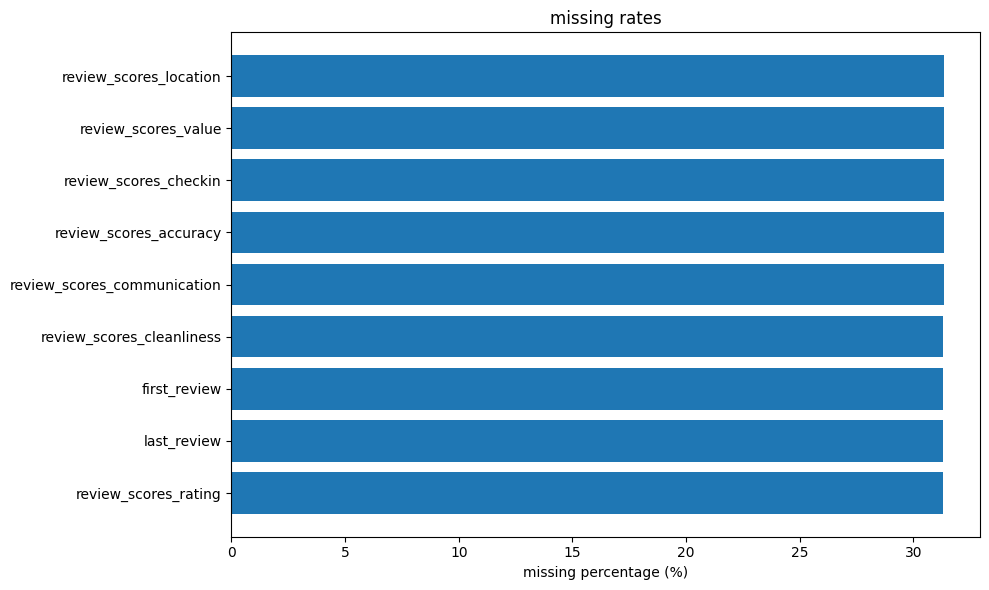

In [49]:
# barchart of missing values（matplotlib）
if not missing_df.empty:
    plt.figure(figsize=(10, max(6, len(missing_df)*0.3)))
    plt.barh(missing_df.index, missing_df['missing percentage'])
    plt.xlabel('missing percentage (%)')
    plt.title('missing rates')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

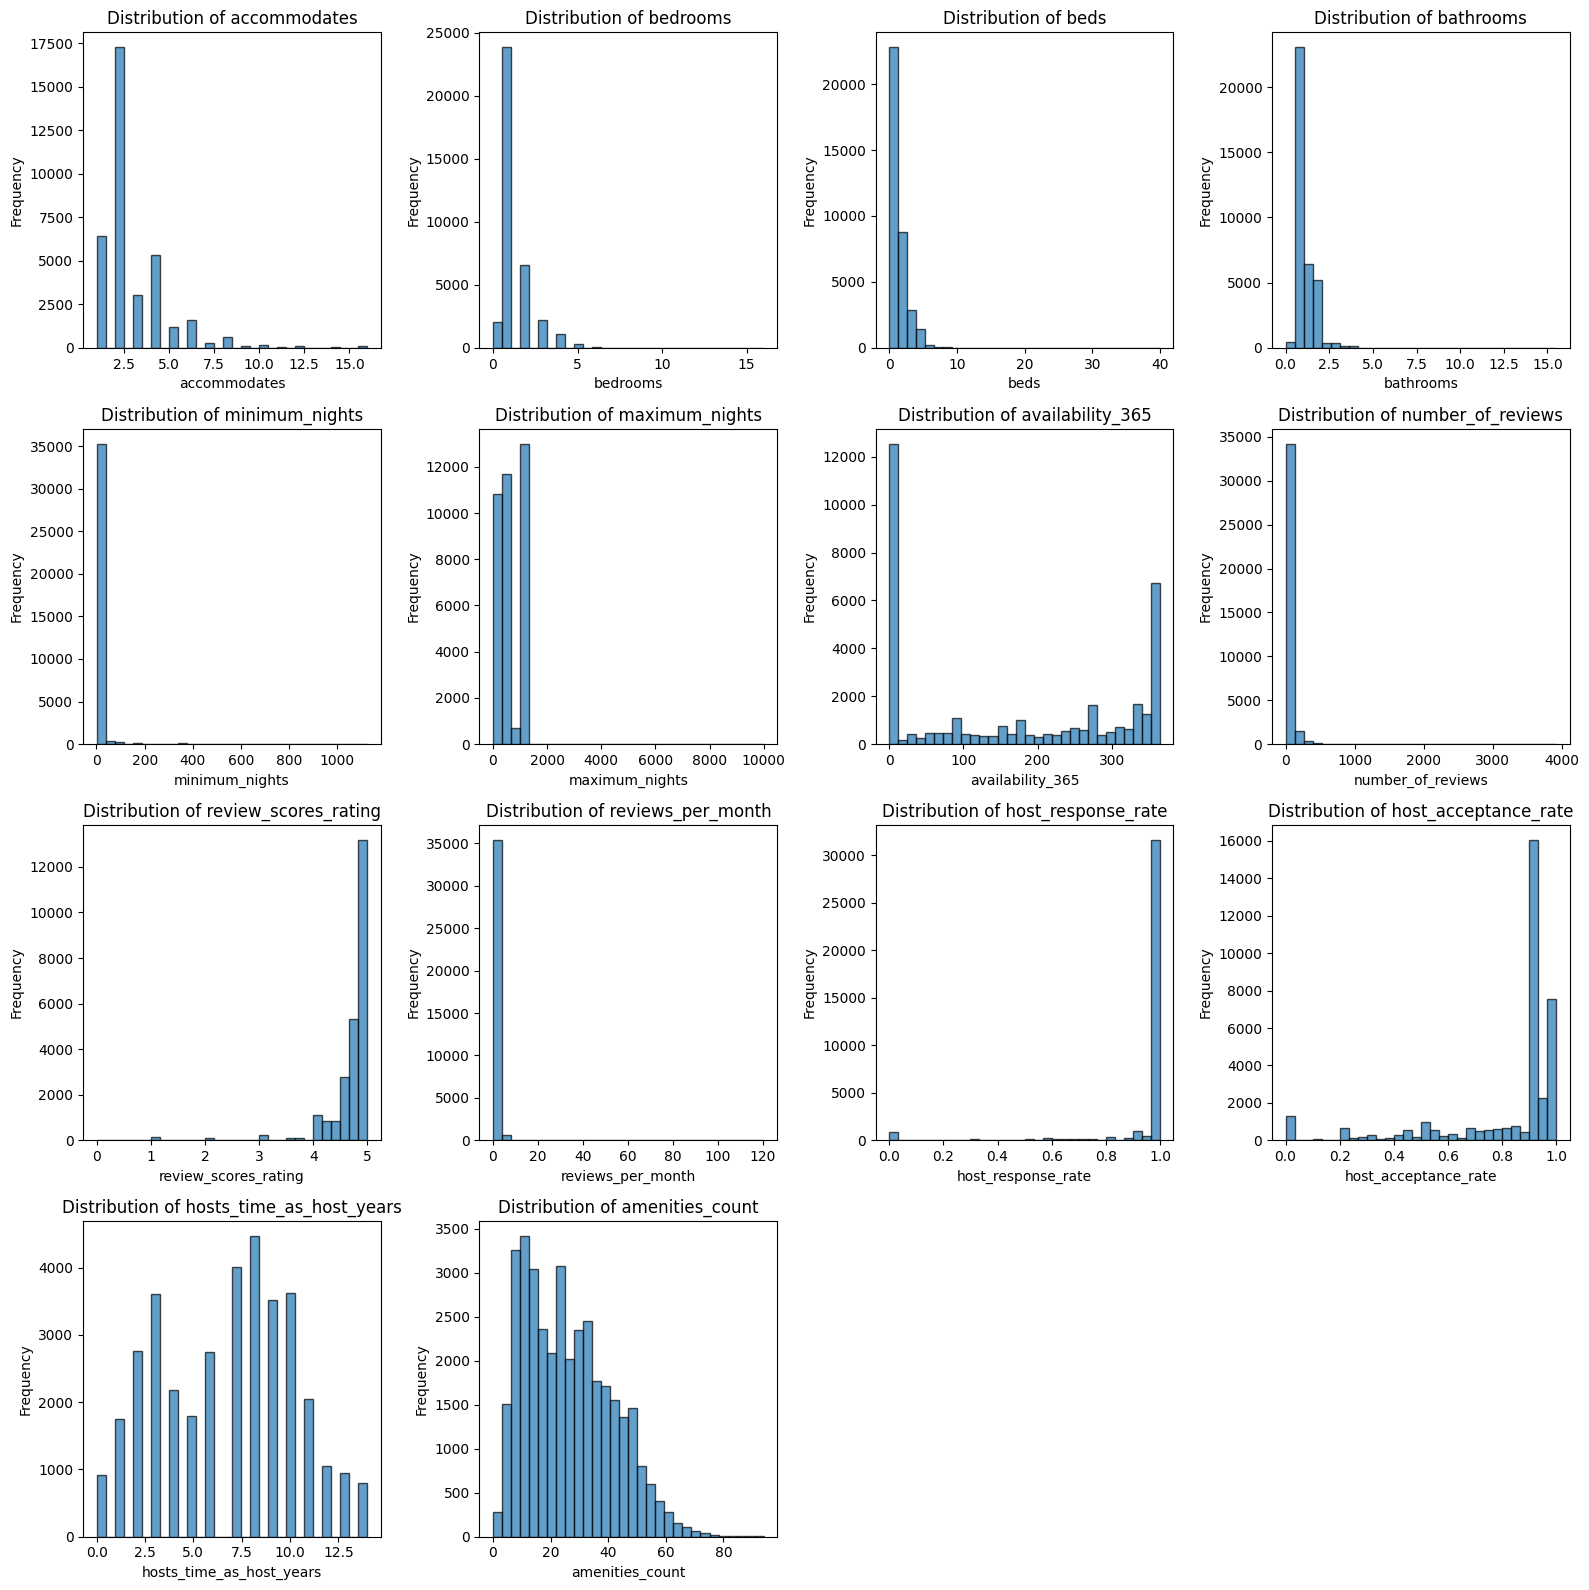

In [50]:
# 4. plottings
plot_num_cols = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 
                 'minimum_nights', 'maximum_nights', 
                 'availability_365', 'number_of_reviews', 
                 'review_scores_rating', 'reviews_per_month',
                 'host_response_rate', 'host_acceptance_rate',
                 'hosts_time_as_host_years', 'amenities_count']
plot_num_cols = [c for c in plot_num_cols if c in df_eda.columns]

n_cols = 4
n_rows = (len(plot_num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(plot_num_cols):
    axes[i].hist(df_eda[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

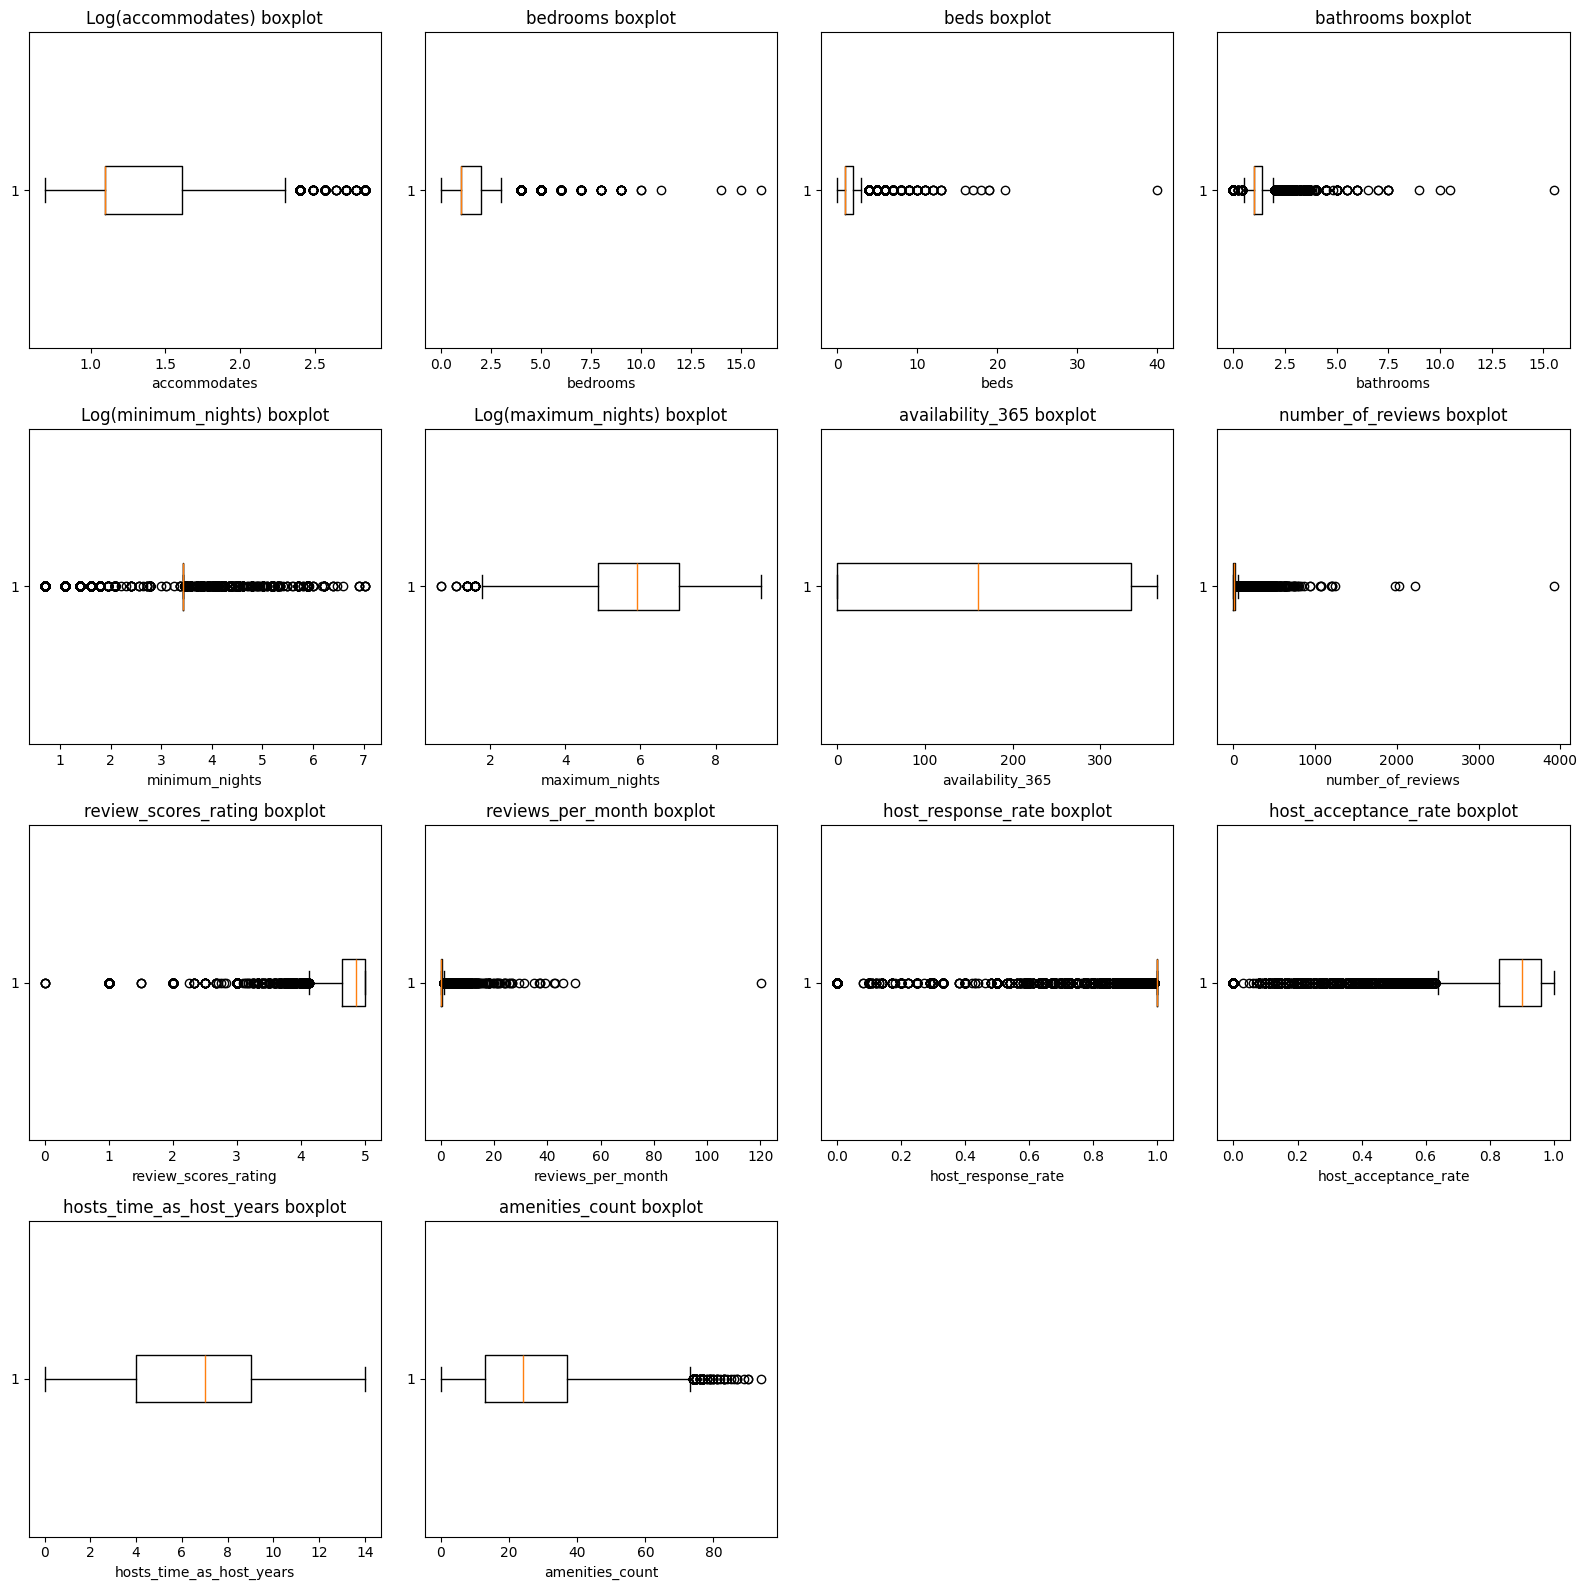

In [51]:
# 5. box plot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()
for i, col in enumerate(plot_num_cols):
    data = df_eda[col].dropna()
    if data.min() > 0 and data.skew() > 1:
        data = np.log1p(data)
        axes[i].set_title(f'Log({col}) boxplot')
    else:
        axes[i].set_title(f'{col} boxplot')
    axes[i].boxplot(data, vert=False)
    axes[i].set_xlabel(col)
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

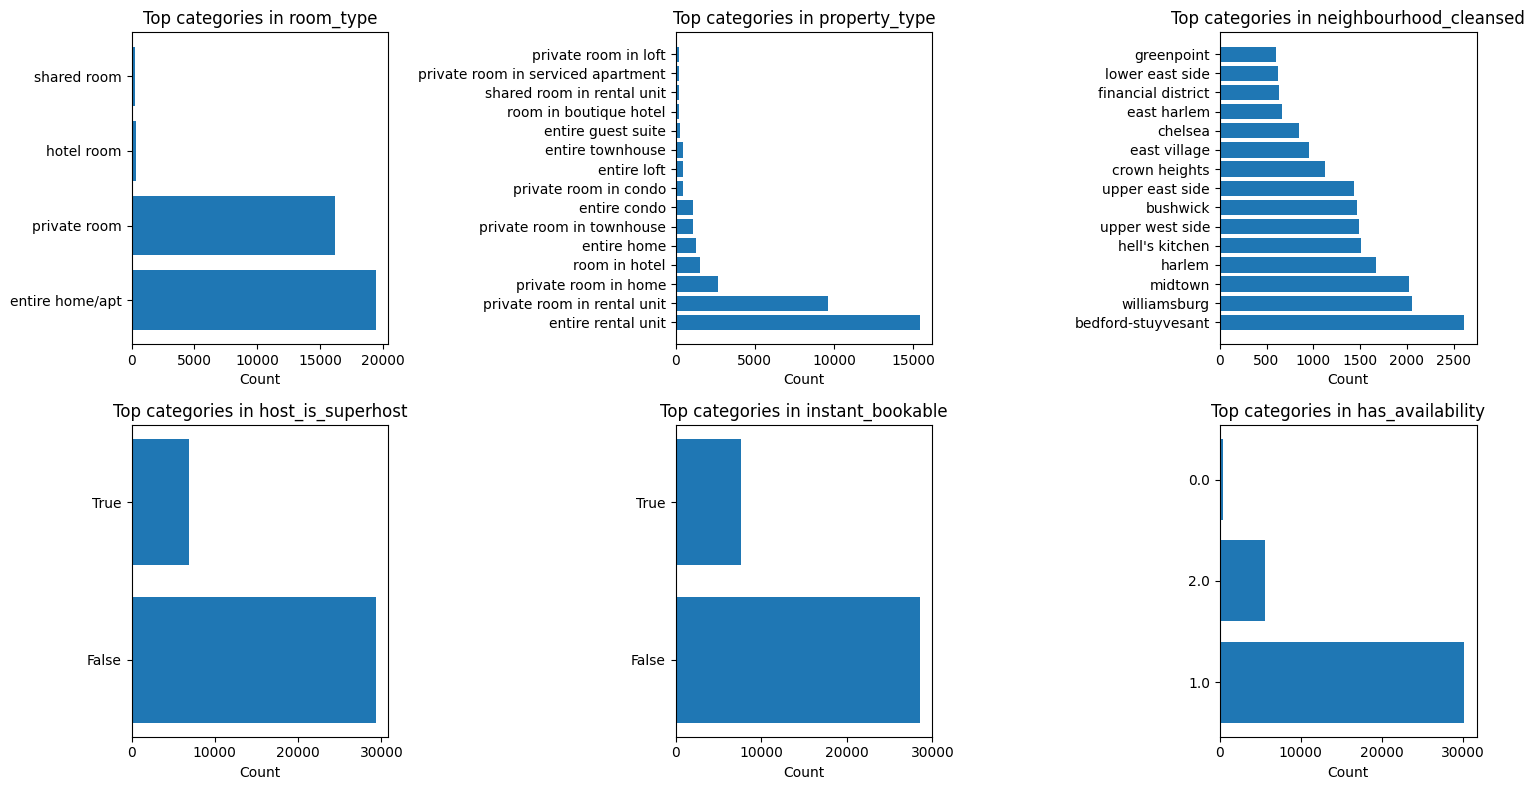

In [52]:
# 6. barchart
cat_plot_cols = ['room_type', 'property_type', 'neighbourhood_cleansed', 
                 'host_is_superhost', 'instant_bookable', 'has_availability']
cat_plot_cols = [c for c in cat_plot_cols if c in df_eda.columns]

n_cols = 3
n_rows = (len(cat_plot_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_plot_cols):
    counts = df_eda[col].value_counts().head(15)
    axes[i].barh(counts.index.astype(str), counts.values)
    axes[i].set_title(f'Top categories in {col}')
    axes[i].set_xlabel('Count')
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

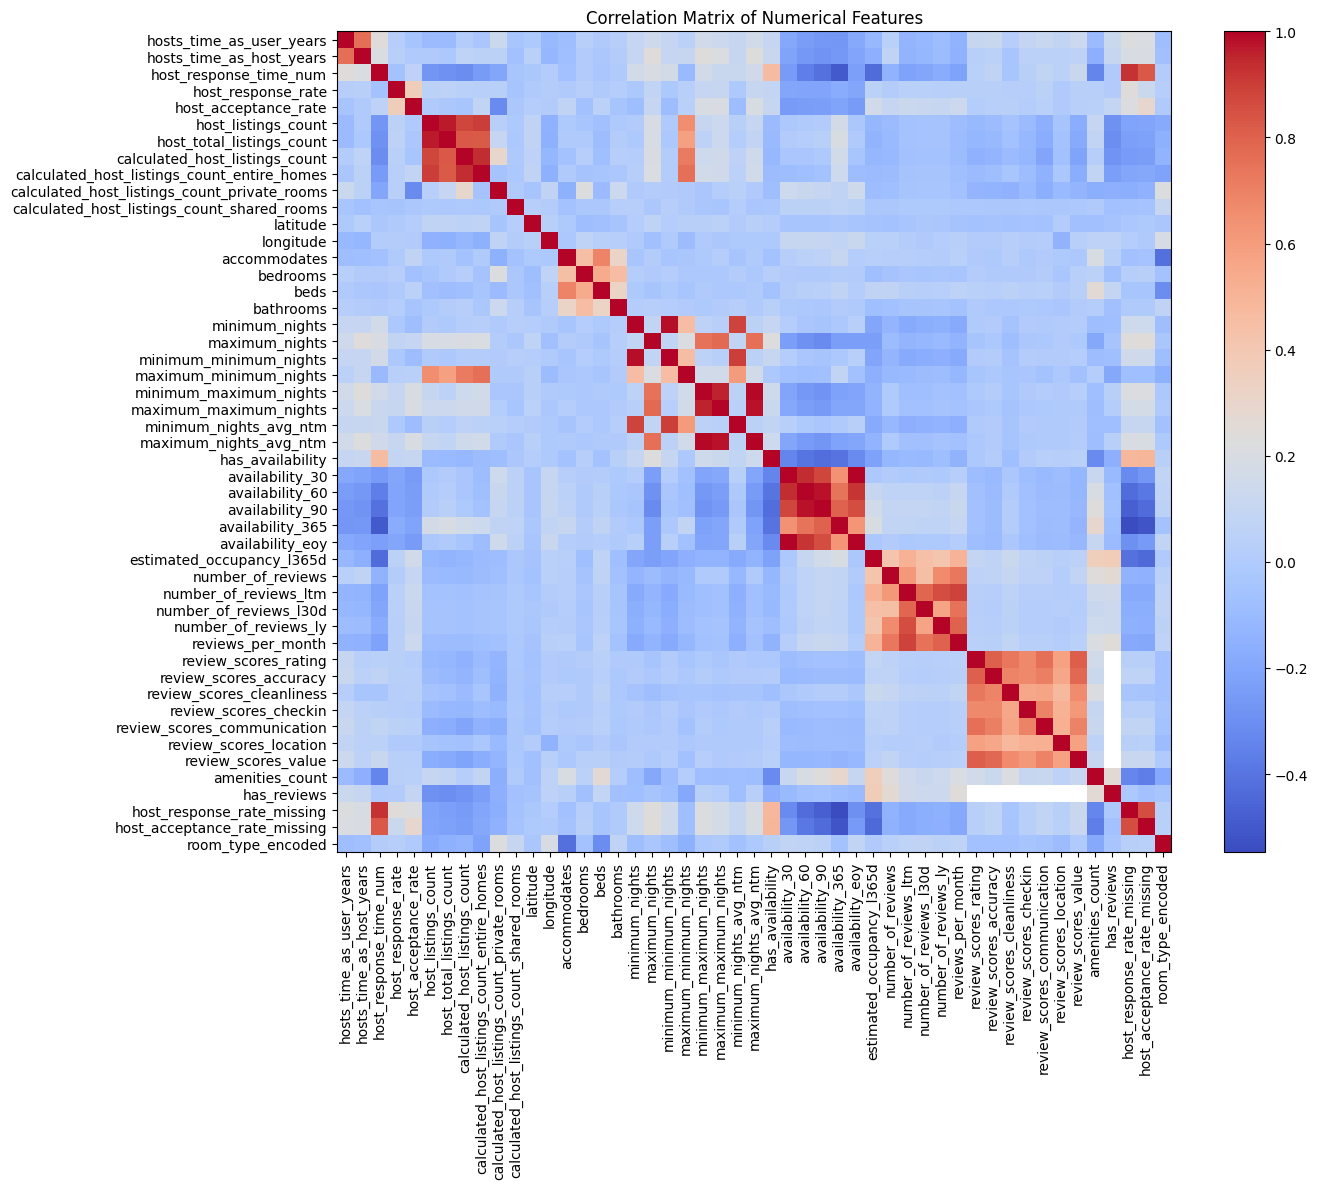


Top 10 variables most correlated with review_scores_rating:
 review_scores_value            0.811867
review_scores_accuracy         0.802834
review_scores_communication    0.752334
review_scores_cleanliness      0.729276
review_scores_checkin          0.673491
review_scores_location         0.582147
amenities_count                0.164006
hosts_time_as_user_years       0.105555
estimated_occupancy_l365d      0.088091
number_of_reviews              0.061038
Name: review_scores_rating, dtype: float64


In [53]:
# 7. correlation matrix heatmap
if len(num_cols) > 0:
    corr = df_eda[num_cols].corr()
    plt.figure(figsize=(14, 12))
    plt.imshow(corr, cmap='coolwarm', aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()

    # correlation with review_scores_rating
    if 'review_scores_rating' in corr.columns:
        target_corr = corr['review_scores_rating'].sort_values(ascending=False)
        print("\nTop 10 variables most correlated with review_scores_rating:\n", 
      target_corr.head(11)[1:])

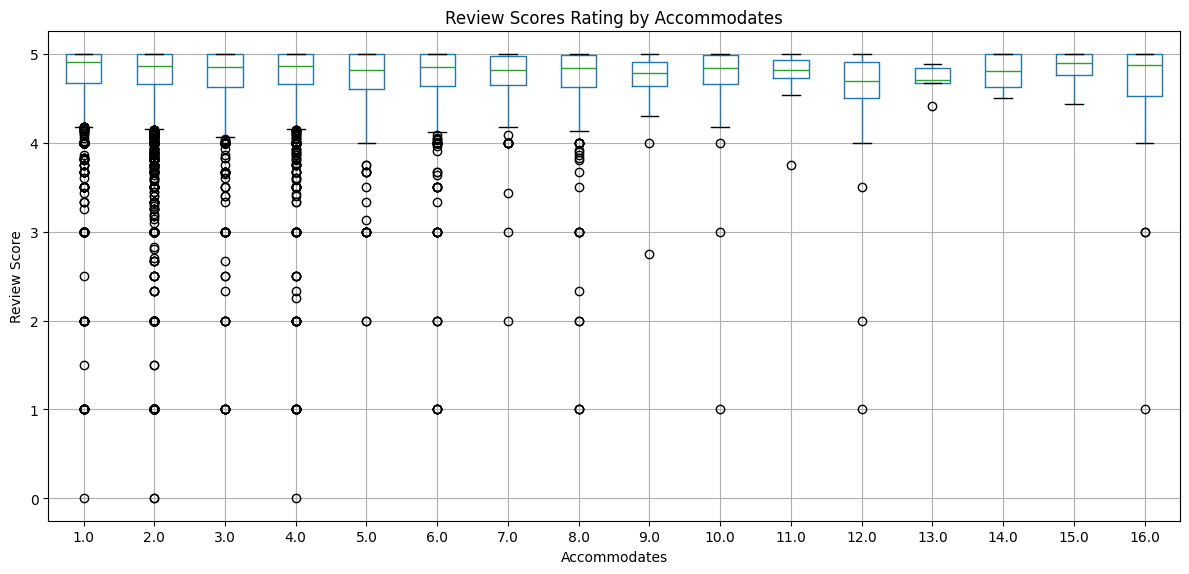

In [54]:
# 8. two variable exploration
if 'review_scores_rating' in df_eda.columns and 'accommodates' in df_eda.columns:
    
    df_eda.boxplot(column='review_scores_rating', by='accommodates', figsize=(12, 6))
    plt.title('Review Scores Rating by Accommodates')
    plt.suptitle('')
    plt.xlabel('Accommodates')
    plt.ylabel('Review Score')
    plt.tight_layout()
    plt.show()

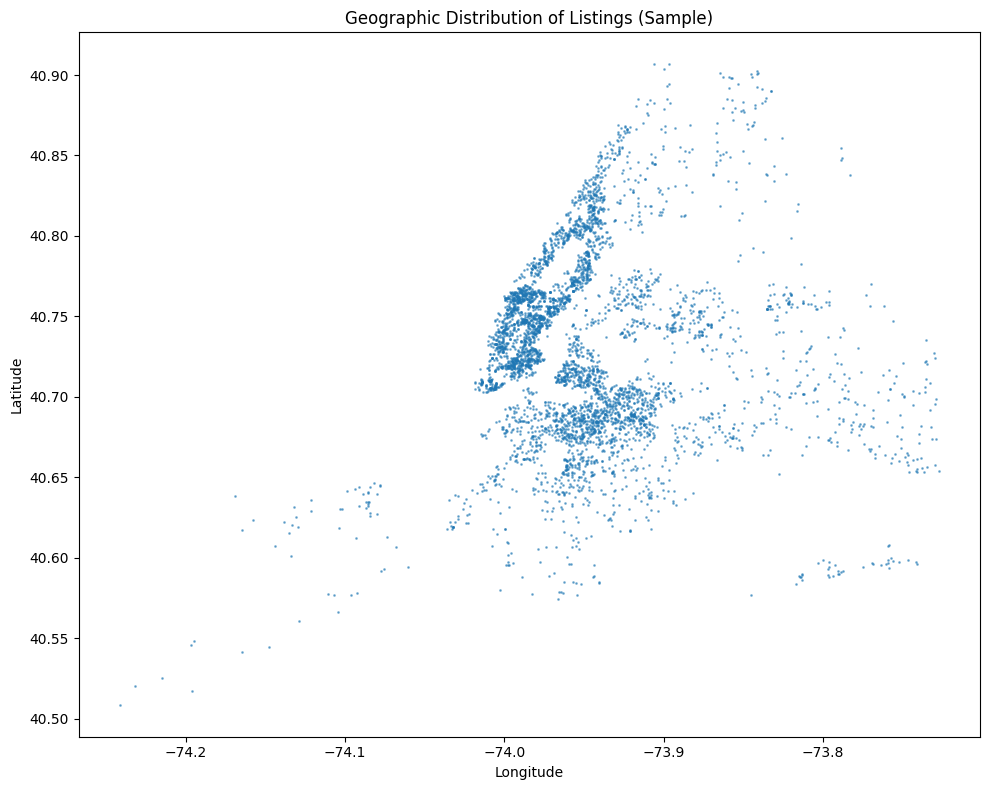

In [55]:
# 9. Geographic Distribution
if 'latitude' in df_eda.columns and 'longitude' in df_eda.columns:
    sample = df_eda.sample(min(5000, len(df_eda)), random_state=42)
    plt.figure(figsize=(10, 8))
    plt.scatter(sample['longitude'], sample['latitude'], alpha=0.5, s=1)
    plt.title('Geographic Distribution of Listings (Sample)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()

Summary: First, print the basic information of the dataset, including the number of rows and columns, the first 5 rows, all column names, and the count of each data type. This is to quickly view the overall size. Second, I compute descriptive statistics for all numerical columns (num_cols), including mean, standard deviation, minimum, quartiles, and maximum. This helps to understand the range, central tendency, and dispersion of each numerical feature, and to detect possible outliers. Third, I calculate the count and percentage of missing values for each column, filter columns with missing data, and sort them by missing percentage in descending order. Then I plot a horizontal bar chart to visually display the missing rate for each column. Forth, I select a set of representative numerical variables and plot histograms (30 bins) for each. Histograms reveal the distribution shape (e.g., normal, skewed, bimodal), central tendency, and possible outliers. Observing the distributions provides a basis for subsequent modeling or transformations (e.g., log transformation). Fifth, Drawing boxplots for the same numerical variables. For variables that are right‑skewed and have all positive values, apply natural logarithm (np.log1p) before plotting. Boxplots intuitively show the median, interquartile range, and outliers. Logarithmic transformation makes skewed distributions more symmetric, facilitating outlier identification and understanding the concentrated range of data.Sixth, it is important to select several important categorical variables, count the frequency of each category, and display the top 15 categories (if applicable) in horizontal bar charts. This quickly reveals the balance of category distributions and provides references for potential category merging or encoding later. The 7th step is to compute the correlation coefficient matrix among all numerical variables and plot a heatmap using imshow. The color intensity indicates the strength of correlation, allowing intuitive discovery of linear relationships between variables. The 8th step is to use boxplots to show the distribution of review scores (review_scores_rating) for different numbers of accommodates. Boxplots compare medians, dispersion, and outliers across groups, helping to explore whether there is a relationship between accommodates and ratings (e.g., whether more accommodates lead to lower ratings). This grouped visualization helps uncover potential patterns. The last step is geographic distribution. Since too many latitude/longitude points can make the plot overcrowded, we can randomly sample up to 5000 observations and use a scatter plot to show the geographic locations of listings (longitude on x‑axis, latitude on y‑axis). This reveals whether listings are concentrated in certain areas or if outliers exist.

# Step 4 - Data Preprocessing and Feature Engineering

Step 4 of the project was done by Jiahao & Jiarong.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import skew
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings('ignore')

In [60]:
df_preprocessed = df_eda.copy()

print("4.1 FEATURE SCALING AND NORMALIZATION")

# --- Log Transformation ---
print("\n[Log Transformation]")
print("Purpose: Reduce right skewness in distributions")
print("Benefit: Improves linear model performance and reduces outlier impact\n")

skewed_features = {
    'number_of_reviews': 'number_of_reviews_log',
    'reviews_per_month': 'reviews_per_month_log',
    'calculated_host_listings_count': 'host_listings_log',
    'amenities_count': 'amenities_count_log'
}

for original, log_name in skewed_features.items():
    if original in df_preprocessed.columns:
        data = df_preprocessed[original].dropna()
        if len(data) > 0 and (data > 0).all():
            skewness = skew(data)
            if abs(skewness) > 1:
                df_preprocessed[log_name] = np.log1p(df_preprocessed[original])
                print(f"✓ Created {log_name} (original skewness: {skewness:.2f})")

# --- Standardization ---
print("\n[Standardization (Z-score)]")
print("Purpose: Scale features to mean=0, std=1")
print("Benefit: Essential for distance-based algorithms (KNN, SVM), faster gradient descent\n")

scaler_std = StandardScaler()
cols_to_standardize = [
    'accommodates', 'bedrooms', 'beds', 'bathrooms',
    'minimum_nights', 'availability_365', 
    'number_of_reviews', 'amenities_count'
]
cols_to_standardize = [col for col in cols_to_standardize if col in df_preprocessed.columns]

for col in cols_to_standardize:
    df_preprocessed[f'{col}_scaled'] = scaler_std.fit_transform(df_preprocessed[[col]])
    print(f"✓ {col}_scaled")

# --- Min-Max Scaling ---
print("\n[Min-Max Scaling]")
print("Purpose: Scale features to [0,1] range")
print("Benefit: Preserves distribution shape, ideal for bounded features like coordinates\n")

minmax_scaler = MinMaxScaler()
cols_to_minmax = ['latitude', 'longitude', 'host_response_rate', 'host_acceptance_rate']
cols_to_minmax = [col for col in cols_to_minmax if col in df_preprocessed.columns]

for col in cols_to_minmax:
    df_preprocessed[f'{col}_minmax'] = minmax_scaler.fit_transform(df_preprocessed[[col]])
    print(f"✓ {col}_minmax")


4.1 FEATURE SCALING AND NORMALIZATION

[Log Transformation]
Purpose: Reduce right skewness in distributions
Benefit: Improves linear model performance and reduces outlier impact

✓ Created host_listings_log (original skewness: 4.26)

[Standardization (Z-score)]
Purpose: Scale features to mean=0, std=1
Benefit: Essential for distance-based algorithms (KNN, SVM), faster gradient descent

✓ accommodates_scaled
✓ bedrooms_scaled
✓ beds_scaled
✓ bathrooms_scaled
✓ minimum_nights_scaled
✓ availability_365_scaled
✓ number_of_reviews_scaled
✓ amenities_count_scaled

[Min-Max Scaling]
Purpose: Scale features to [0,1] range
Benefit: Preserves distribution shape, ideal for bounded features like coordinates

✓ latitude_minmax
✓ longitude_minmax
✓ host_response_rate_minmax
✓ host_acceptance_rate_minmax


In [61]:
print("4.2 CATEGORICAL ENCODING")

# --- Binary Encoding ---
print("\n[Binary Encoding]")
print("Purpose: Convert True/False categorical variables to 0/1")
print("Benefit: Efficient representation without dimensionality increase\n")

boolean_cols = ['host_is_superhost', 'host_has_profile_pic', 
                'host_identity_verified', 'instant_bookable', 
                'bathroom_shared', 'bathroom_private']

for col in boolean_cols:
    if col in df_preprocessed.columns:
        if df_preprocessed[col].dtype == 'boolean':
            df_preprocessed[f'{col}_binary'] = df_preprocessed[col].astype(int)
            print(f"✓ {col}_binary")

# --- Frequency Encoding ---
print("\n[Frequency Encoding]")
print("Purpose: Handle high-cardinality categorical features")
print("Benefit: Avoids dimensionality explosion while capturing category popularity\n")

high_card_cols = ['neighbourhood_cleansed', 'property_type']

for col in high_card_cols:
    if col in df_preprocessed.columns:
        freq_map = df_preprocessed[col].value_counts(normalize=True).to_dict()
        df_preprocessed[f'{col}_freq'] = df_preprocessed[col].map(freq_map)
        n_categories = df_preprocessed[col].nunique()
        print(f"✓ {col}_freq ({n_categories} categories)")

# --- One-Hot Encoding ---
print("\n[One-Hot Encoding]")
print("Purpose: Convert low-cardinality nominal variables to binary columns")
print("Benefit: Clear interpretation, compatible with all algorithms\n")

if 'room_type' in df_preprocessed.columns:
    room_dummies = pd.get_dummies(df_preprocessed['room_type'], prefix='room', drop_first=True)
    df_preprocessed = pd.concat([df_preprocessed, room_dummies], axis=1)
    print(f"✓ room_type one-hot: {len(room_dummies.columns)} features")

# --- Rare Category Grouping ---
print("\n[Grouping Rare Categories]")
print("Purpose: Reduce dimensionality by combining infrequent categories")
print("Benefit: Prevents overfitting on rare categories with few samples\n")

if 'property_type' in df_preprocessed.columns:
    property_freq = df_preprocessed['property_type'].value_counts(normalize=True)
    rare_categories = property_freq[property_freq < 0.01].index.tolist()
    df_preprocessed['property_grouped'] = df_preprocessed['property_type'].apply(
        lambda x: 'other' if x in rare_categories else x
    )
    
    property_dummies = pd.get_dummies(df_preprocessed['property_grouped'], 
                                      prefix='prop', drop_first=True)
    df_preprocessed = pd.concat([df_preprocessed, property_dummies], axis=1)
    print(f"✓ Grouped {len(rare_categories)} rare types → {len(property_dummies.columns)} dummies")

4.2 CATEGORICAL ENCODING

[Binary Encoding]
Purpose: Convert True/False categorical variables to 0/1
Benefit: Efficient representation without dimensionality increase

✓ host_is_superhost_binary
✓ host_has_profile_pic_binary
✓ host_identity_verified_binary
✓ instant_bookable_binary
✓ bathroom_shared_binary
✓ bathroom_private_binary

[Frequency Encoding]
Purpose: Handle high-cardinality categorical features
Benefit: Avoids dimensionality explosion while capturing category popularity

✓ neighbourhood_cleansed_freq (224 categories)
✓ property_type_freq (74 categories)

[One-Hot Encoding]
Purpose: Convert low-cardinality nominal variables to binary columns
Benefit: Clear interpretation, compatible with all algorithms

✓ room_type one-hot: 3 features

[Grouping Rare Categories]
Purpose: Reduce dimensionality by combining infrequent categories
Benefit: Prevents overfitting on rare categories with few samples

✓ Grouped 64 rare types → 10 dummies


In [62]:
print("4.3 OUTLIER HANDLING")
print("Purpose: Reduce impact of extreme values on model training")
print("Methods: Winsorization (5% from each tail) and Percentile Capping\n")

# --- Winsorization ---
print("[Winsorization]")
print("Capping extreme values at 5th and 95th percentiles\n")

def winsorize_series(s, limits=[0.05, 0.05]):
    """Apply winsorization to reduce extreme outliers"""
    return winsorize(s, limits=limits)

# Apply to features with known outliers
outlier_features = ['number_of_reviews', 'calculated_host_listings_count']
for col in outlier_features:
    if col in df_preprocessed.columns:
        original_min = df_preprocessed[col].min()
        original_max = df_preprocessed[col].max()
        
        df_preprocessed[f'{col}_winsorized'] = winsorize_series(df_preprocessed[col])
        df_preprocessed[col] = df_preprocessed[f'{col}_winsorized']
        df_preprocessed.drop(columns=[f'{col}_winsorized'], inplace=True)
        
        new_min = df_preprocessed[col].min()
        new_max = df_preprocessed[col].max()
        print(f"✓ {col}: [{original_min:.0f}, {original_max:.0f}] → [{new_min:.0f}, {new_max:.0f}]")

# --- Percentile Capping ---
print("\n[Percentile Capping]")
print("Capping at 99th percentile for highly skewed features\n")

cap_features = ['availability_365', 'minimum_nights']
for col in cap_features:
    if col in df_preprocessed.columns:
        cap_value = df_preprocessed[col].quantile(0.99)
        original_max = df_preprocessed[col].max()
        
        df_preprocessed[col] = np.where(
            df_preprocessed[col] > cap_value, 
            cap_value, 
            df_preprocessed[col]
        )
        print(f"✓ {col}: capped at {cap_value:.0f} (original max: {original_max:.0f})")

4.3 OUTLIER HANDLING
Purpose: Reduce impact of extreme values on model training
Methods: Winsorization (5% from each tail) and Percentile Capping

[Winsorization]
Capping extreme values at 5th and 95th percentiles

✓ number_of_reviews: [0, 3920] → [0, 141]
✓ calculated_host_listings_count: [1, 1189] → [1, 330]

[Percentile Capping]
Capping at 99th percentile for highly skewed features

✓ availability_365: capped at 365 (original max: 365)
✓ minimum_nights: capped at 90 (original max: 1124)


In [63]:
print("4.4 REMOVE NEAR-ZERO VARIANCE FEATURES")
print("Purpose: Remove features with little to no variation")
print("Benefit: Reduces dimensionality, speeds up training, prevents numerical issues\n")

# Check variance of numerical features
num_features = df_preprocessed.select_dtypes(include=[np.number]).columns
variance = df_preprocessed[num_features].var()

print("Features with variance < 0.01:")
low_var = variance[variance < 0.01]
for col, var in low_var.items():
    print(f"  - {col}: {var:.6f}")

# Apply variance threshold
vt = VarianceThreshold(threshold=0.01)
X_num = df_preprocessed[num_features].fillna(0)
vt.fit(X_num)
features_to_keep = X_num.columns[vt.get_support()]
features_to_drop = set(num_features) - set(features_to_keep)

if features_to_drop:
    print(f"\n✓ Removing {len(features_to_drop)} near-zero variance features:")
    for feat in features_to_drop:
        print(f"  - {feat}")
    df_preprocessed = df_preprocessed.drop(columns=list(features_to_drop))
else:
    print("\n✓ No near-zero variance features found")

4.4 REMOVE NEAR-ZERO VARIANCE FEATURES
Purpose: Remove features with little to no variation
Benefit: Reduces dimensionality, speeds up training, prevents numerical issues

Features with variance < 0.01:
  - latitude: 0.003172
  - longitude: 0.003032
  - neighbourhood_cleansed_freq: 0.000493

✓ Removing 3 near-zero variance features:
  - longitude
  - latitude
  - neighbourhood_cleansed_freq


In [64]:
print("4.5 ADVANCED FEATURE ENGINEERING")
print("Creating domain-specific features to enhance predictive power\n")

# --- Category 1: HOST QUALITY ---
print("[Host Quality Features]")
print("Purpose: Capture host experience and service quality")
print("Business Impact: Better hosts → higher occupancy rates and prices\n")

if 'hosts_time_as_host_years' in df_preprocessed.columns:
    superhost_col = 'host_is_superhost_binary' if 'host_is_superhost_binary' in df_preprocessed.columns else 'host_is_superhost'
    if superhost_col in df_preprocessed.columns:
        superhost_val = pd.to_numeric(df_preprocessed[superhost_col], errors='coerce').fillna(0)
        df_preprocessed['host_experience_score'] = (
            df_preprocessed['hosts_time_as_host_years'] * 0.7 + superhost_val * 5
        )
        print("✓ host_experience_score (combines tenure + superhost status)")

if 'host_response_rate' in df_preprocessed.columns and 'host_acceptance_rate' in df_preprocessed.columns:
    df_preprocessed['host_responsiveness_score'] = (
        df_preprocessed['host_response_rate'] * 0.6 +
        df_preprocessed['host_acceptance_rate'] * 0.4
    )
    print("✓ host_responsiveness_score (weighted: 60% response + 40% acceptance)")

if 'host_total_listings_count' in df_preprocessed.columns:
    df_preprocessed['host_portfolio_log'] = np.log1p(df_preprocessed['host_total_listings_count'])
    print("✓ host_portfolio_log (professional vs casual host indicator)")

# --- Category 2: PROPERTY CHARACTERISTICS ---
print("\n[Property Features]")
print("Purpose: Capture space utilization and quality metrics")
print("Business Impact: Space efficiency affects guest comfort and pricing\n")

if 'accommodates' in df_preprocessed.columns and 'bedrooms' in df_preprocessed.columns:
    df_preprocessed['people_per_bedroom'] = df_preprocessed['accommodates'] / (df_preprocessed['bedrooms'] + 0.1)
    print("✓ people_per_bedroom (crowding indicator)")

if 'beds' in df_preprocessed.columns and 'bedrooms' in df_preprocessed.columns:
    df_preprocessed['bed_bedroom_ratio'] = df_preprocessed['beds'] / (df_preprocessed['bedrooms'] + 0.1)
    print("✓ bed_bedroom_ratio (room configuration type)")

if 'bathrooms' in df_preprocessed.columns and 'accommodates' in df_preprocessed.columns:
    df_preprocessed['bathroom_per_person'] = df_preprocessed['bathrooms'] / (df_preprocessed['accommodates'] + 0.1)
    print("✓ bathroom_per_person (comfort indicator)")

if all(col in df_preprocessed.columns for col in ['accommodates', 'bedrooms', 'beds', 'bathrooms']):
    df_preprocessed['capacity_score'] = (
        df_preprocessed['accommodates'] * 0.4 +
        df_preprocessed['bedrooms'] * 0.3 +
        df_preprocessed['beds'] * 0.2 +
        df_preprocessed['bathrooms'] * 0.1
    )
    print("✓ capacity_score (overall property capacity)")

# --- Category 3: BOOKING FLEXIBILITY ---
print("\n[Booking Flexibility Features]")
print("Purpose: Capture booking policy flexibility")
print("Business Impact: Flexible policies attract different guest segments\n")

if 'minimum_nights' in df_preprocessed.columns and 'maximum_nights' in df_preprocessed.columns:
    df_preprocessed['nights_flexibility'] = np.log1p(
        df_preprocessed['maximum_nights'] - df_preprocessed['minimum_nights']
    )
    print("✓ nights_flexibility (booking policy range)")

if 'minimum_nights' in df_preprocessed.columns:
    df_preprocessed['short_stay_friendly'] = (df_preprocessed['minimum_nights'] <= 3).astype(int)
    print("✓ short_stay_friendly (tourist/business traveler friendly)")

if 'maximum_nights' in df_preprocessed.columns:
    df_preprocessed['long_stay_friendly'] = (df_preprocessed['maximum_nights'] >= 90).astype(int)
    print("✓ long_stay_friendly (remote worker friendly)")

if 'availability_365' in df_preprocessed.columns:
    df_preprocessed['availability_rate'] = df_preprocessed['availability_365'] / 365
    print("✓ availability_rate (normalized availability)")

# --- Category 4: REVIEW METRICS ---
print("\n[Review Features]")
print("Purpose: Capture guest satisfaction and demand indicators")
print("Business Impact: Reviews strongly correlate with bookings and pricing power\n")

if 'reviews_per_month' in df_preprocessed.columns:
    df_preprocessed['review_frequency_score'] = np.log1p(df_preprocessed['reviews_per_month'])
    print("✓ review_frequency_score (booking frequency proxy)")

if 'number_of_reviews' in df_preprocessed.columns:
    df_preprocessed['review_volume_log'] = np.log1p(df_preprocessed['number_of_reviews'])
    print("✓ review_volume_log (credibility indicator)")

if 'last_review' in df_preprocessed.columns:
    try:
        last_review_dt = pd.to_datetime(df_preprocessed['last_review'], errors='coerce')
        reference_date = pd.to_datetime('2024-12-31')
        days_since = (reference_date - last_review_dt).dt.days
        df_preprocessed['days_since_last_review'] = days_since
        df_preprocessed['review_recency_score'] = 1 / (1 + days_since / 365)
        print("✓ review_recency_score (active listing indicator)")
    except:
        print("✗ Could not create review_recency_score")

rating_cols = [col for col in df_preprocessed.columns if 'review_scores' in col and col != 'review_scores_rating']
if len(rating_cols) > 0:
    df_preprocessed['review_comprehensive_score'] = df_preprocessed[rating_cols].mean(axis=1)
    print(f"✓ review_comprehensive_score (averaged from {len(rating_cols)} dimensions)")

# --- Category 5: LOCATION FEATURES ---
print("\n[Location Features]")
print("Purpose: Capture geographic desirability")
print("Business Impact: Location is the #1 driver of Airbnb prices\n")

if 'latitude' in df_preprocessed.columns and 'longitude' in df_preprocessed.columns:
    center_lat, center_lon = 40.7580, -73.9855  # NYC Times Square
    df_preprocessed['distance_from_center'] = np.sqrt(
        (df_preprocessed['latitude'] - center_lat)**2 +
        (df_preprocessed['longitude'] - center_lon)**2
    ) * 111  # Convert to km
    df_preprocessed['is_downtown'] = (df_preprocessed['distance_from_center'] <= 5).astype(int)
    print("✓ distance_from_center (km from Times Square)")
    print("✓ is_downtown (within 5km of center)")

if 'neighbourhood_cleansed' in df_preprocessed.columns:
    neighborhood_count = df_preprocessed['neighbourhood_cleansed'].value_counts()
    df_preprocessed['neighborhood_popularity'] = df_preprocessed['neighbourhood_cleansed'].map(neighborhood_count)
    df_preprocessed['neighborhood_pop_log'] = np.log1p(df_preprocessed['neighborhood_popularity'])
    print("✓ neighborhood_popularity (listing density)")

# --- Category 6: AMENITIES FEATURES ---
print("\n[Amenity Features]")
print("Purpose: Capture property amenities and luxury level")
print("Business Impact: Premium amenities justify higher pricing\n")

if 'amenities_list' in df_preprocessed.columns:
    high_value = ['wifi', 'kitchen', 'air conditioning', 'heating', 
                  'washer', 'dryer', 'pool', 'gym']
    
    for amenity in high_value:
        col_name = f'has_{amenity.replace(" ", "_")}'
        df_preprocessed[col_name] = df_preprocessed['amenities_list'].apply(
            lambda x: int(any(amenity in str(item).lower() for item in x)) if isinstance(x, list) else 0
        )
    
    amenity_cols = [f'has_{a.replace(" ", "_")}' for a in high_value]
    df_preprocessed['premium_amenities_score'] = df_preprocessed[amenity_cols].sum(axis=1)
    print(f"✓ {len(high_value)} amenity binary features")
    print("✓ premium_amenities_score (luxury level: 0-8)")

# --- Category 7: INTERACTION FEATURES ---
print("\n[Interaction Features]")
print("Purpose: Capture non-additive relationships between features")
print("Business Impact: Combinations reveal complex pricing patterns\n")

if 'number_of_reviews' in df_preprocessed.columns and 'availability_365' in df_preprocessed.columns:
    df_preprocessed['review_efficiency'] = df_preprocessed['number_of_reviews'] / (df_preprocessed['availability_365'] + 1)
    print("✓ review_efficiency (booking rate per available night)")

if 'host_total_listings_count' in df_preprocessed.columns and 'hosts_time_as_host_years' in df_preprocessed.columns:
    df_preprocessed['listings_per_year'] = df_preprocessed['host_total_listings_count'] / (df_preprocessed['hosts_time_as_host_years'] + 0.1)
    print("✓ listings_per_year (host growth rate)")

# --- Category 8: POLYNOMIAL FEATURES ---
print("\n[Polynomial Features]")
print("Purpose: Capture non-linear relationships")
print("Business Impact: Price often scales exponentially with capacity\n")

polynomial_cols = ['accommodates', 'bedrooms', 'number_of_reviews']
for col in polynomial_cols:
    if col in df_preprocessed.columns:
        df_preprocessed[f'{col}_squared'] = df_preprocessed[col] ** 2
        print(f"✓ {col}_squared")

# --- Category 9: BINNED FEATURES ---
print("\n[Binned Features]")
print("Purpose: Create market segments from continuous variables")
print("Business Impact: Discrete segments capture non-linear threshold effects\n")

if 'accommodates' in df_preprocessed.columns:
    df_preprocessed['size_category'] = pd.cut(
        df_preprocessed['accommodates'],
        bins=[0, 2, 4, 6, np.inf],
        labels=['small', 'medium', 'large', 'xlarge']
    )
    print("✓ size_category (property size segment)")

if 'number_of_reviews' in df_preprocessed.columns:
    df_preprocessed['review_volume_category'] = pd.cut(
        df_preprocessed['number_of_reviews'],
        bins=[0, 10, 50, 100, np.inf],
        labels=['new', 'established', 'popular', 'very_popular']
    )
    print("✓ review_volume_category (credibility tier)")


4.5 ADVANCED FEATURE ENGINEERING
Creating domain-specific features to enhance predictive power

[Host Quality Features]
Purpose: Capture host experience and service quality
Business Impact: Better hosts → higher occupancy rates and prices

✓ host_experience_score (combines tenure + superhost status)
✓ host_responsiveness_score (weighted: 60% response + 40% acceptance)
✓ host_portfolio_log (professional vs casual host indicator)

[Property Features]
Purpose: Capture space utilization and quality metrics
Business Impact: Space efficiency affects guest comfort and pricing

✓ people_per_bedroom (crowding indicator)
✓ bed_bedroom_ratio (room configuration type)
✓ bathroom_per_person (comfort indicator)
✓ capacity_score (overall property capacity)

[Booking Flexibility Features]
Purpose: Capture booking policy flexibility
Business Impact: Flexible policies attract different guest segments

✓ nights_flexibility (booking policy range)
✓ short_stay_friendly (tourist/business traveler friendly)


4.6 CREATING VISUALIZATIONS
Generating 3 key visualizations to demonstrate preprocessing impact

[1/3] Transformation Effect Comparison...


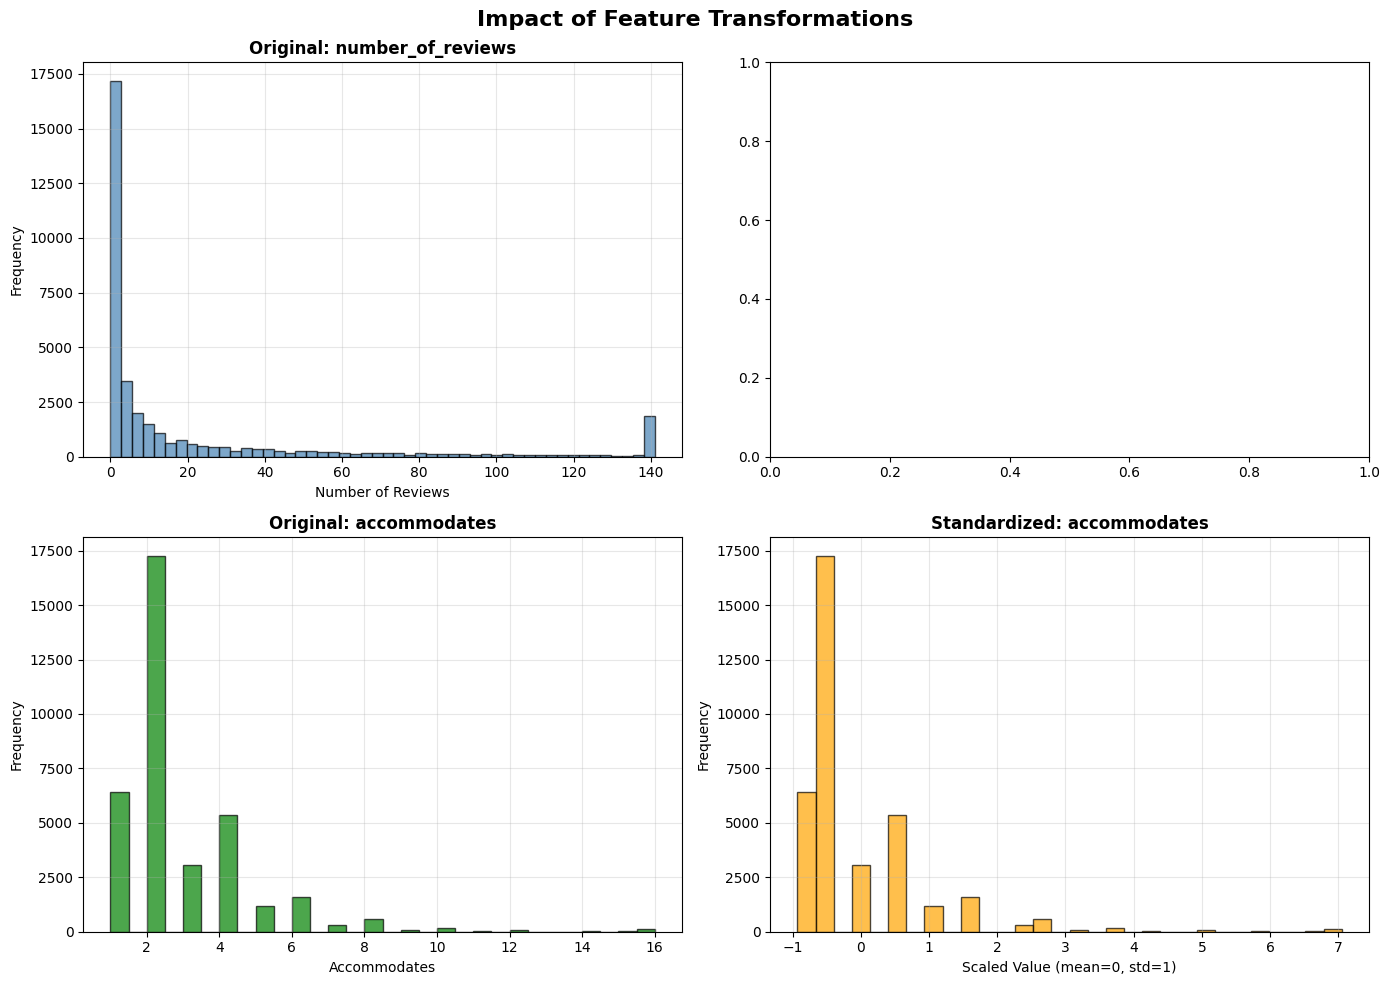

✓ Completed

[2/3] Engineered Features Showcase...


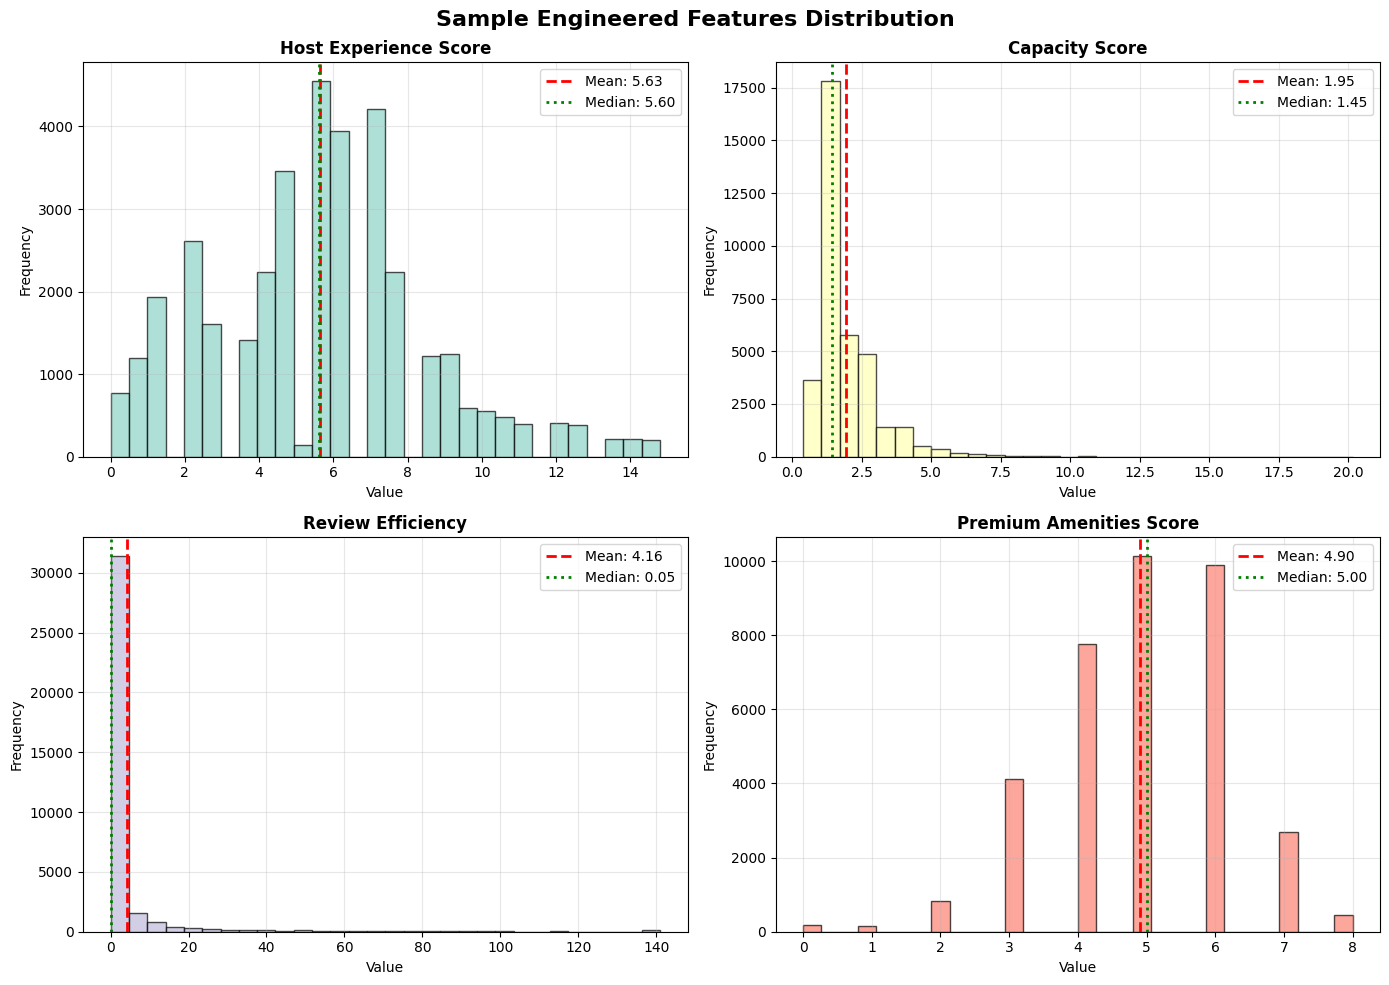

✓ Completed

[3/3] Feature Engineering Summary Chart...


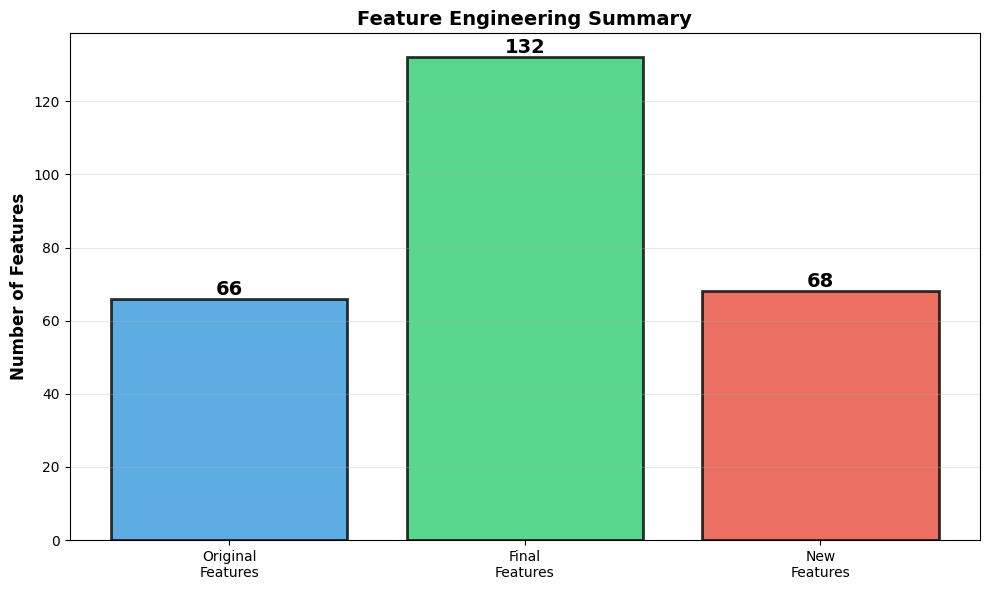

In [65]:
print("4.6 CREATING VISUALIZATIONS")
print("Generating 3 key visualizations to demonstrate preprocessing impact\n")

original_cols = set(df_eda.columns)
new_cols = set(df_preprocessed.columns) - original_cols
engineered_features = list(new_cols)

# --- Visualization 1: Transformation Comparison ---
print("[1/3] Transformation Effect Comparison...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Impact of Feature Transformations', fontsize=16, fontweight='bold')

# Number of reviews: original vs log
if 'number_of_reviews' in df_preprocessed.columns:
    axes[0, 0].hist(df_preprocessed['number_of_reviews'].dropna(), bins=50, 
                    alpha=0.7, color='steelblue', edgecolor='black')
    axes[0, 0].set_title('Original: number_of_reviews', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Number of Reviews')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(alpha=0.3)
    
    if 'number_of_reviews_log' in df_preprocessed.columns:
        axes[0, 1].hist(df_preprocessed['number_of_reviews_log'].dropna(), bins=50, 
                        alpha=0.7, color='coral', edgecolor='black')
        axes[0, 1].set_title('Log-transformed: number_of_reviews', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Log(Number of Reviews)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].grid(alpha=0.3)

# Accommodates: original vs scaled
if 'accommodates' in df_preprocessed.columns:
    axes[1, 0].hist(df_preprocessed['accommodates'].dropna(), bins=30, 
                    alpha=0.7, color='green', edgecolor='black')
    axes[1, 0].set_title('Original: accommodates', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Accommodates')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(alpha=0.3)
    
    if 'accommodates_scaled' in df_preprocessed.columns:
        axes[1, 1].hist(df_preprocessed['accommodates_scaled'].dropna(), bins=30, 
                        alpha=0.7, color='orange', edgecolor='black')
        axes[1, 1].set_title('Standardized: accommodates', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Scaled Value (mean=0, std=1)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
print("✓ Completed")

# --- Visualization 2: Engineered Features Showcase ---
print("\n[2/3] Engineered Features Showcase...")

showcase = ['host_experience_score', 'capacity_score', 
            'review_efficiency', 'premium_amenities_score']
showcase = [f for f in showcase if f in df_preprocessed.columns]

if len(showcase) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()
    fig.suptitle('Sample Engineered Features Distribution', fontsize=16, fontweight='bold')
    
    for idx, feature in enumerate(showcase[:4]):
        data = df_preprocessed[feature].dropna()
        axes[idx].hist(data, bins=30, color=plt.cm.Set3(idx), 
                      edgecolor='black', alpha=0.7)
        axes[idx].set_title(feature.replace('_', ' ').title(), 
                           fontweight='bold', fontsize=12)
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(alpha=0.3)
        
        # Add statistics
        mean_val = data.mean()
        median_val = data.median()
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                         label=f'Mean: {mean_val:.2f}')
        axes[idx].axvline(median_val, color='green', linestyle=':', linewidth=2, 
                         label=f'Median: {median_val:.2f}')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()
    print("✓ Completed")

# --- Visualization 3: Feature Count Summary ---
print("\n[3/3] Feature Engineering Summary Chart...")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
categories = ['Original\nFeatures', 'Final\nFeatures', 'New\nFeatures']
counts = [len(df_eda.columns), len(df_preprocessed.columns), len(engineered_features)]
colors = ['#3498db', '#2ecc71', '#e74c3c']

bars = ax.bar(categories, counts, color=colors, alpha=0.8, 
              edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_title('Feature Engineering Summary', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Summary: In Step 4, advanced data preprocessing and feature engineering techniques were applied to prepare the dataset for robust analysis and potential modeling. Log transformations were applied to right-skewed features such as calculated_host_listings_count. Standardization (z-score) was applied to structural features like accommodates, bedrooms, and availability, while min-max scaling was used for geographic and rate variables. Boolean columns were converted to binary integers, frequency encoding was applied to high-cardinality categoricals (neighbourhood_cleansed, property_type), and one-hot encoding was used for room_type. Rare property types (< 1% frequency) were consolidated into an "Other" group before encoding. Nine categories of engineered features were created, including host quality scores, property ratios, booking flexibility indicators, review metrics, location features (distance from city center), amenity flags, interaction terms, polynomial features, and binned size/review categories.

In [68]:
# ======================================================
# 4.X FINAL PROCESSED DATASET: FINALIZE + EXPORT
# ======================================================

import os
import numpy as np
import pandas as pd

print("Preparing final processed dataset...")

# 0) Start from the final dataframe produced in Step 4
df_final = df_preprocessed.copy()

# 1) Replace inf values (can appear after log/division feature engineering)
df_final = df_final.replace([np.inf, -np.inf], np.nan)

# 2) Drop columns that are NOT appropriate in a final processed CSV
#    (raw text, list-like columns, raw categorical columns that already have encoded versions, etc.)
cols_to_drop = []

# Common raw columns in Airbnb-style datasets (drop if they still exist)
raw_drop_list = [
    "room_type",
    "property_type",
    "property_grouped",
    "neighbourhood_cleansed",
    "amenities",
    "amenities_list",
    "host_about",
    "name",
    "description",
    "neighborhood_overview"
]
for col in raw_drop_list:
    if col in df_final.columns:
        cols_to_drop.append(col)

# Automatically drop list/dict/set/tuple columns (often breaks clean CSV modeling)
for col in df_final.columns:
    sample = df_final[col].dropna().head(20)
    if len(sample) > 0 and sample.apply(lambda x: isinstance(x, (list, dict, set, tuple))).any():
        cols_to_drop.append(col)

cols_to_drop = sorted(set(cols_to_drop))
if cols_to_drop:
    df_final.drop(columns=cols_to_drop, inplace=True)
    print(f"✓ Dropped {len(cols_to_drop)} non-modeling-friendly columns:")
    print(cols_to_drop)

# 3) Handle missing values safely (fixes your Categorical fillna(0) error)
#    - numeric -> fill with 0 (or median)
#    - categorical/object -> fill with "Missing" (and add category first if needed)
num_cols = df_final.select_dtypes(include=[np.number]).columns
cat_cols = df_final.select_dtypes(include=["object", "category"]).columns

# numeric fill
before_na = int(df_final.isna().sum().sum())
df_final[num_cols] = df_final[num_cols].fillna(0)

# categorical fill
for col in cat_cols:
    if pd.api.types.is_categorical_dtype(df_final[col]):
        if "Missing" not in df_final[col].cat.categories:
            df_final[col] = df_final[col].cat.add_categories(["Missing"])
    df_final[col] = df_final[col].fillna("Missing")

# 4) One-hot encode any remaining categorical columns (keeps dataset modeling-ready)
#    If you already encoded most columns earlier, this will only encode what's left.
cat_cols_after = df_final.select_dtypes(include=["object", "category"]).columns.tolist()
if len(cat_cols_after) > 0:
    df_final = pd.get_dummies(df_final, columns=cat_cols_after, drop_first=True)
    print(f"✓ One-hot encoded remaining categorical columns: {cat_cols_after}")
else:
    print("✓ No remaining categorical columns to one-hot encode.")

# 5) Final sanity checks
after_na = int(df_final.isna().sum().sum())
print("\nFinal dataset shape:", df_final.shape)
print("Remaining missing values:", after_na)
print("Dtype counts:\n", df_final.dtypes.value_counts())

# 6) Save final processed dataset
out_path = "airbnb_final_processed_dataset.csv"

df_final.to_csv(out_path, index=False)
print(f"\n✅ Final processed dataset saved to: {out_path}")


Preparing final processed dataset...
✓ Dropped 7 non-modeling-friendly columns:
['amenities_list', 'host_verifications', 'name', 'neighbourhood_cleansed', 'property_grouped', 'property_type', 'room_type']
✓ One-hot encoded remaining categorical columns: ['size_category', 'review_volume_category']

Final dataset shape: (36227, 131)
Remaining missing values: 22684
Dtype counts:
 float64            57
int64              37
bool               18
boolean             9
string              3
Float64             3
datetime64[us]      2
int64[pyarrow]      1
double[pyarrow]     1
Name: count, dtype: int64

✅ Final processed dataset saved to: airbnb_final_processed_dataset.csv
